In [ ]:
"""
3/19/2021

Goal:
Visualization of model (Random forest) results

1. Feature importance
2. Density by label

"""

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, log_loss

pd.set_option('display.max_columns', None)

## Load data and create df
* .csv files already include both blurriness and face info (with more details)
* larger dataset(1832 rows)

In [7]:
bad = pd.read_csv('./OpenCV_blur/TEST_face_features_bad_bare.csv')
good = pd.read_csv('./OpenCV_blur/TEST_face_features_good_bare.csv')
len(bad),len(good)

(808, 1024)

In [8]:
test = pd.concat([bad,good],axis=0).reset_index(drop=True)
test.shape

(1832, 16)

In [9]:
import ast
# Convert to actual list and count number of eyes/ears/nose detected
test['eyes'] = test['eyes'].apply(lambda x: ast.literal_eval(x))
test['num_eye'] = test['eyes'].apply(lambda x: len(x))
test['ears'] = test['ears'].apply(lambda x: ast.literal_eval(x))
test['num_ear'] = test['ears'].apply(lambda x: len(x))
test['nose'] = test['nose'].apply(lambda x: ast.literal_eval(x))
test['num_nose'] = test['nose'].apply(lambda x: len(x))

# eye position
test['eye_x1'] = test['eyes'].apply(lambda x: x[0][0] if (len(x)>0) else 0)
test['eye_y1'] = test['eyes'].apply(lambda x: x[0][1] if (len(x)>0) else 0)
test['eye_x2'] = test['eyes'].apply(lambda x: x[1][0] if (len(x)>1) else 0)
test['eye_y2'] = test['eyes'].apply(lambda x: x[1][1] if (len(x)>1) else 0)
# eye width
test['eye_w1'] = test['eyes'].apply(lambda x: x[0][2] if (len(x)>0) else 0)
test['eye_w2'] = test['eyes'].apply(lambda x: x[1][2] if (len(x)>1) else 0)
test['eye_w'] = test['eyes'].apply(lambda x: sum([x[i][2] for i in range(len(x))])/len(x) if len(x)!=0 else 0)
# eye height
test['eye_h1'] = test['eyes'].apply(lambda x: x[0][3] if (len(x)>0) else 0)
test['eye_h2'] = test['eyes'].apply(lambda x: x[1][3] if (len(x)>1) else 0)
test['eye_h'] = test['eyes'].apply(lambda x: sum([x[i][3] for i in range(len(x))])/len(x) if len(x)!=0 else 0)
# eye size and ratio to face size
test['eye_size'] = test['eye_w']*test['eye_h']
test['eye_ratio'] = test['eye_size'] / test['face_size']

# nose position
test['nose_x'] = test['nose'].apply(lambda x: x[0][0] if (len(x)>0) else 0)
test['nose_y'] = test['nose'].apply(lambda x: x[0][1] if (len(x)>0) else 0)

# ear width
test['ear_w1'] = test['ears'].apply(lambda x: x[0][2] if (len(x)>0) else 0)
test['ear_w2'] = test['ears'].apply(lambda x: x[1][2] if (len(x)>1) else 0)
test['ear_w'] = test['ears'].apply(lambda x: sum([x[i][2] for i in range(len(x))])/len(x) if len(x)!=0 else 0)
# ear height
test['ear_h1'] = test['ears'].apply(lambda x: x[0][3] if (len(x)>0) else 0)
test['ear_h2'] = test['ears'].apply(lambda x: x[1][3] if (len(x)>1) else 0)
test['ear_h'] = test['ears'].apply(lambda x: sum([x[i][3] for i in range(len(x))])/len(x) if len(x)!=0 else 0)

In [10]:
# add video column
test['video'] = test['filename'].apply(lambda x: x.split('.M')[0])
test['video'] = test['filename'].apply(lambda x: x.lower().split('.m')[0])

# Examine cat face detection
test['avg_face'] = test.groupby(['video'])['face_size'].transform(np.mean)
test['avg_to_ctr'] = test.groupby(['video'])['to_ctr'].transform(np.mean)
# Correct face_size
correct_face = test.apply(lambda x: x.face_size if x.face_size>10000 else x.avg_face, axis=1)
test['face_size'] = correct_face
# Correct to_ctr
correct_to_crt = test.apply(lambda x: x.to_ctr if x.face_size>10000 else x.avg_to_ctr, axis=1)

In [11]:
# Add 'label' as the last column
label_list = ['bad']*bad.shape[0] + ['good']*good.shape[0]
test['label'] = label_list
# test.iloc[:,:]

In [12]:
data = test.copy()

### A. Conventional train test split

In [13]:
df = data.copy()
# Train test split
X = df.iloc[:,:-1]

mapping = {'bad':0, 'good':1}
y = df['label'].map(mapping)

X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)

### B. Proper train test split

In [244]:
# Make sure all the frames in test set are from videos not seen in training set
# Test set size: ~367 frames
df = data.copy()
# df.head(370)

In [245]:
video_file = 'IMG_0185'
temp_df = df[df.video == video_file][['face_size','avg_face','video']]
# temp_df.face_size.hist(bins=50);

In [246]:
ax = sns.boxplot(x="video", y="face_size", data=temp_df)
ax = sns.swarmplot(x="video", y="face_size", data=temp_df, color=".25")

ValueError: min() arg is an empty sequence

In [247]:
# temp_df.sort_values('face_size')

In [248]:
df.video.unique()

array(['img_0185', 'img_0186', 'img_0187', 'img_0242', 'img_0243',
       'img_0244', 'img_0245', 'img_0246', 'img_0250', 'img_0251',
       'img_0253', 'img_0257', 'img_0258', 'img_0259', 'img_0261',
       'img_0262', 'img_0263', 'img_0267', 'img_0268', 'img_0271',
       'img_3554', 'img_3572', 'img_4245', 'img_5179.trim', 'img_8976',
       'img_9181', 'img_9953', 'junskitchen_1', 'img_3555',
       'joined_video_54ba02eb70fc40e4a4d6dd164fd11e70'], dtype=object)

In [249]:
df.video.nunique()

30

In [286]:
# Use frames from 12 videos as test set
test_video = df.groupby('video').count().iloc[10:22,:].index.tolist()
len(test_video)

12

In [287]:
# Separate features and target
X = df.iloc[:,:-4]

mapping = {'bad':0, 'good':1}
y = df['label'].map(mapping)


# Manual tran test split
X_train_df = df[~df.video.isin(test_video)].iloc[:,:-4]
X_test_df = df[df.video.isin(test_video)].iloc[:,:-4]

y_train = df[~df.video.isin(test_video)]['label'].map(mapping)
y_test = df[df.video.isin(test_video)]['label'].map(mapping)

In [288]:
len(X_train_df),len(X_test_df)

(1704, 128)

### Reset train_df and test_df index

In [14]:
# Reset index
X_train_df.reset_index(inplace=True,drop=True)
X_test_df.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)

In [15]:
# X_test_df

In [16]:
X_test_df.columns

Index(['filename', 'lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny',
       'lp_all_canny', 'lp_ratio_canny', 'blur', 'to_ctr', 'cat_x', 'cat_y',
       'face_size', 'size_ratio', 'eyes', 'ears', 'nose', 'num_eye', 'num_ear',
       'num_nose', 'eye_x1', 'eye_y1', 'eye_x2', 'eye_y2', 'eye_w1', 'eye_w2',
       'eye_w', 'eye_h1', 'eye_h2', 'eye_h', 'eye_size', 'eye_ratio', 'nose_x',
       'nose_y', 'ear_w1', 'ear_w2', 'ear_w', 'ear_h1', 'ear_h2', 'ear_h',
       'video', 'avg_face', 'avg_to_ctr'],
      dtype='object')

In [17]:
# X_test_df.info()

In [18]:
# y_test

## Scale continuous variables

In [19]:
headers = ['filename','lp_cat','lp_all','lp_ratio','lp_cat_canny','lp_all_canny','lp_ratio_canny','blur',\
               'to_ctr','cat_x','cat_y','face_size','size_ratio',\
               'eyes','ears','nose']

In [20]:
# Continuous variables
features = ['lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny', 'lp_all_canny', 'lp_ratio_canny',\
#             'cat_x', 'cat_y',
            'face_size', 'size_ratio', 'to_ctr',\
            'num_eye','num_ear', 'num_nose', 
            'eye_w1', 'eye_w2', 'eye_w', 'eye_h1', 'eye_h2', 'eye_h',
            'eye_size', 'eye_ratio',
            'ear_w1', 'ear_w2', 'ear_w', 'ear_h1', 'ear_h2', 'ear_h',
#             'eye_x1', 'eye_y1', 'eye_x2', 'eye_y2',
#             'nose_x'
           ]
X_train_con = X_train_df[features]

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train_con_scaled = scaler.fit_transform(X_train_df[features])
cont_columns = X_train_con.columns
X_train_con_df = pd.DataFrame(X_train_con_scaled, columns=cont_columns, index=X_train_con.index)
# X_train_con_df

In [21]:
# Try without 'blur'
X_train = X_train_con_df

In [22]:
# # Combine Con and Cat
# X_train = pd.concat([X_train_con_df,X_train_df[['blur']]], axis='columns')
# X_train

In [23]:
# Repeat for test set
# Continuous variables
# features = ['lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny', 'lp_all_canny', 'lp_ratio_canny', 'size_ratio', 'to_ctr']
X_test_con = X_test_df[features]

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_test_con_scaled = scaler.fit_transform(X_test_df[features])
cont_columns = X_test_con.columns
X_test_con_df = pd.DataFrame(X_test_con_scaled, columns=cont_columns, index=X_test_con.index)

# Combine Con and Cat
X_test = pd.concat([X_test_con_df,X_test_df[['blur']]], axis='columns')
# X_test

In [24]:
# Try without 'blur'
X_test = X_test_con_df

## 1. Logistic regression

### A. Basic

In [25]:
from sklearn.linear_model import LogisticRegression

lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
print('intercept: ', round(lm.intercept_[0], 4))
lr_features = pd.DataFrame(list(zip(X_train.columns,np.transpose(lm.coef_[0]))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)
lr_features.head()

intercept:  0.1672


Feature      Coef
20        ear_w1  2.193073
7     size_ratio  2.180997
0         lp_cat  2.098791
16        eye_h2  1.926551
3   lp_cat_canny  1.753772

In [26]:
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-Bad (0)','Predict-Good (1)'],\
            index=['Bad (0)','Good (1)'])

Predict-Bad (0)  Predict-Good (1)
Bad (0)               113                41
Good (1)               19               194

In [27]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion/np.sum(fraud_confusion), cmap=plt.cm.Blues,
           annot=True, square=True, fmt='.2%',
           xticklabels=['Bad', 'Good'],
           yticklabels=['Bad', 'Good']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [28]:
from ipywidgets import interactive, FloatSlider
interactive(lambda threshold: make_confusion_matrix(lm, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [29]:
print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

Accuracy score: 0.8365122615803815 

Classification report (Logistic regression):

               precision    recall  f1-score   support

           0       0.86      0.73      0.79       154
           1       0.83      0.91      0.87       213

    accuracy                           0.84       367
   macro avg       0.84      0.82      0.83       367
weighted avg       0.84      0.84      0.83       367



In [30]:
# Define plot_roc function
def plot_roc(model_name,model):
    y_scores = model.predict_proba(X_test)
    fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC of '+ model_name)
    plt.show()

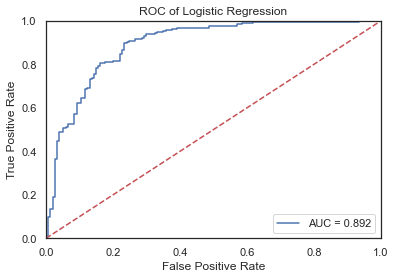

In [31]:
# Logistic regression ROC curve
plot_roc('Logistic Regression', lm)

### B. Hyperparameter Tuning

In [32]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [33]:
# note that train and validation sets are not split properly!

In [34]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.806113 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


In [35]:
# Use best model on test set
lm_best = grid_result.estimator
lm_best.fit(X_train,y_train)
y_predict = lm_best.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-Bad (0)','Predict-Good (1)'],\
            index=['Bad (0)','Good (1)'])

Predict-Bad (0)  Predict-Good (1)
Bad (0)               113                41
Good (1)               19               194

In [36]:
print('intercept: ', round(lm.intercept_[0], 4))
pd.DataFrame(list(zip(X_train.columns,np.transpose(lm_best.coef_[0]))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False).head(5)

intercept:  0.1672


Feature      Coef
7     size_ratio  1.921227
3   lp_cat_canny  1.625550
20        ear_w1  1.409363
16        eye_h2  1.348784
0         lp_cat  1.088009

In [37]:
print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

Accuracy score: 0.8365122615803815 

Classification report (Logistic regression):

               precision    recall  f1-score   support

           0       0.86      0.73      0.79       154
           1       0.83      0.91      0.87       213

    accuracy                           0.84       367
   macro avg       0.84      0.82      0.83       367
weighted avg       0.84      0.84      0.83       367



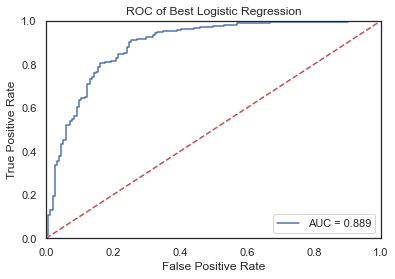

In [38]:
# Logistic regression ROC curve
plot_roc('Best Logistic Regression', lm_best)

In [39]:
# Only small improvement compared to the basic model!

## 2. Random Forests

### A. Basic

In [40]:
def quick_test(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

def quick_test_afew_times(model, X_train, y_train, X_test, y_test, n=10):
    return np.mean([quick_test(model, X_train, y_train, X_test, y_test) for j in range(n)])

In [41]:
from sklearn.ensemble import RandomForestClassifier
# Random Forests
randomforest = RandomForestClassifier(n_estimators=200)
quick_test_afew_times(randomforest, X_train, y_train, X_test, y_test)

0.9024523160762943

In [42]:
# Save the model! (pickle)
import pickle
randomforest.fit(X_train, y_train)
pickle.dump(randomforest, open('./dump/randomforest.pkl','wb'))

In [43]:
pred = randomforest.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Random Forests):\n\n',classification_report(y_test,pred))

Accuracy score: 0.9073569482288828 

Classification report (Random Forests):

               precision    recall  f1-score   support

           0       0.87      0.92      0.89       154
           1       0.94      0.90      0.92       213

    accuracy                           0.91       367
   macro avg       0.90      0.91      0.91       367
weighted avg       0.91      0.91      0.91       367



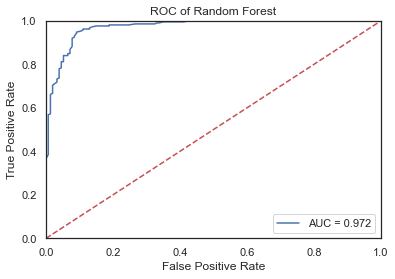

In [44]:
# Random Forest ROC curve
plot_roc('Random Forest', randomforest)

In [45]:
interactive(lambda threshold: make_confusion_matrix(randomforest, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

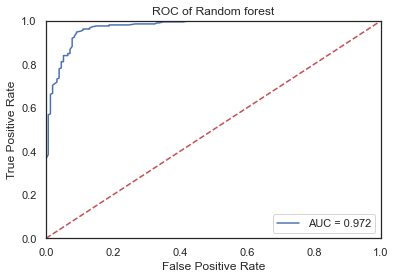

In [46]:
# def plot_roc(model_name,model):
model_name = 'Random forest'
model = randomforest
y_scores = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1],drop_intermediate=False)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC of '+ model_name)
plt.show()

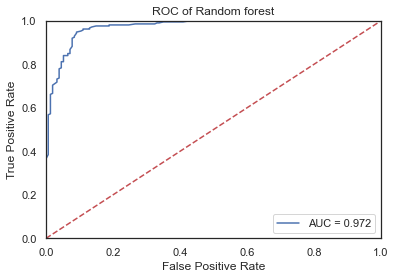

In [47]:
# def plot_roc(model_name,model):
model_name = 'Random forest'
model = randomforest
y_scores = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1],drop_intermediate=True)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC of '+ model_name)
plt.show()

In [48]:
fpr

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00649351, 0.00649351, 0.00649351, 0.00649351, 0.00649351,
       0.00649351, 0.00649351, 0.00649351, 0.00649351, 0.00649351,
       0.00649351, 0.00649351, 0.00649351, 0.00649351, 0.01298701,
       0.01298701, 0.01298701, 0.01298701, 0.01298701, 0.01298701,
       0.01948052, 0.01948052, 0.01948052, 0.01948052, 0.03246753,
       0.03246753, 0.03896104, 0.03896104, 0.03896104, 0.03896104,
       0.04545455, 0.04545455, 0.04545455, 0.04545455, 0.04545455,
       0.05194805, 0.05194805, 0.06493506, 0.06493506, 0.07142857,
       0.07142857, 0.07792208, 0.07792208, 0.07792208, 0.07792208,
       0.07792208, 0.08441558, 0.08441558, 0.09090909, 0.09090909,
       0.1038961 , 0.11038961, 0.11038961, 0.12987013, 0.12987013,
       0.13636364, 0.14935065, 0.18831169, 0.18831169, 0.20779

In [49]:
tpr

array([0.        , 0.02347418, 0.0657277 , 0.10328638, 0.14084507,
       0.15492958, 0.18309859, 0.20657277, 0.23474178, 0.25821596,
       0.27699531, 0.29577465, 0.31455399, 0.342723  , 0.36619718,
       0.38497653, 0.4084507 , 0.42253521, 0.43192488, 0.43661972,
       0.4600939 , 0.46478873, 0.4741784 , 0.47887324, 0.48826291,
       0.5258216 , 0.54460094, 0.54929577, 0.56807512, 0.57276995,
       0.58215962, 0.5915493 , 0.61971831, 0.62441315, 0.66197183,
       0.66666667, 0.67605634, 0.69483568, 0.70422535, 0.71830986,
       0.73239437, 0.7370892 , 0.74647887, 0.76056338, 0.77934272,
       0.78403756, 0.79342723, 0.79812207, 0.80751174, 0.81220657,
       0.81220657, 0.84037559, 0.84037559, 0.84976526, 0.84976526,
       0.8685446 , 0.88262911, 0.89201878, 0.90610329, 0.91549296,
       0.92018779, 0.92488263, 0.92957746, 0.94366197, 0.94835681,
       0.95305164, 0.95774648, 0.96244131, 0.96244131, 0.96713615,
       0.97183099, 0.97652582, 0.97652582, 0.98122066, 0.98122

In [50]:
len(fpr)

114

In [51]:
fpr_tpr = pd.DataFrame([fpr,tpr]).transpose().reset_index(drop=True)
fpr_tpr.columns = ['fpr','tpr']
# fpr_tpr

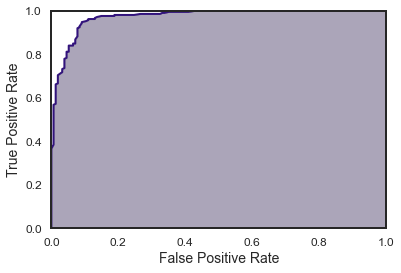

In [52]:
fig, ax = plt.subplots()

# # pd.DataFrame(tpr,fpr).plot.area(alpha=0.4)
# y_scores = lm.predict_proba(X_test)
# fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
# roc_auc = auc(fpr, tpr)

plt.stackplot(fpr, tpr,alpha=0.5,color='#584D74')
# plt.plot(fpr, tpr,'o',color='cadetblue',alpha=0.6,fillstyle='none',ms=3)
plt.plot(fpr, tpr, color='#32137C', linewidth=2, label = 'Logistic Regression = %0.3f' % roc_auc)

# plt.plot([0, 1], [0, 1],'k--',label = 'Random guess = 0.5')

# plt.legend(loc = 'lower right',bbox_to_anchor=(1.6, 0))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
# plt.title('Receiver Operating Characteristic Curve',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

# fig.savefig('./plot/ROC_rf.pdf', bbox_inches='tight', transparent=True)

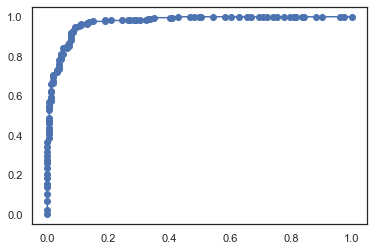

In [53]:
x = fpr
y = tpr
plt.plot(x,y,'o-');

In [54]:
mean_fpr = np.linspace(0,1,100)
interp_tpr = np.interp(mean_fpr, fpr, tpr)

In [55]:
# interp_tpr

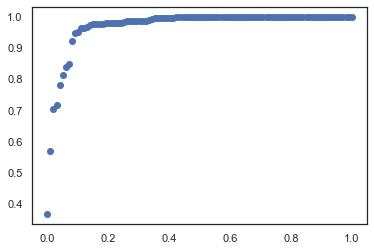

In [56]:
x = mean_fpr
y = interp_tpr
plt.plot(x,y,'o');

In [354]:
# y_scores

In [ ]:
def my_roc_curve(y, prob):
    tpr_list = []
    fpr_list = []
    threshold = np.linspace(1.1, 0, 2000)
    for t in threshold:
        y_pred = np.zeros(y.shape[0])
        y_pred[prob >= t] = 1
        TN = y_pred[(y_pred == y) & (y == 0)].shape[0]
        TP = y_pred[(y_pred == y) & (y == 1)].shape[0]
        FP = y_pred[(y_pred != y) & (y == 0)].shape[0]
        FN = y_pred[(y_pred != y) & (y == 1)].shape[0]
        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        tpr_list.append(TPR)
        fpr_list.append(FPR)
    return fpr_list, tpr_list, threshold

def my_predict_proba(x):
    return(np.random.uniform(0, 1, x.shape[0]))

# prob = my_predict_proba(x)
fpr, tpr, threshold = my_roc_curve(y_test, y_scores[:, 1])

plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)

plt.show()

In [498]:
model
estimator = model.estimators_[5]

In [500]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, 
                out_file='tree.dot', 
                feature_names = X_test.columns,
                class_names = ['Bad','Good'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [503]:
# Convert to png
from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

In [504]:
# Display in jupyter notebook
from IPython.display import Image
# Image(filename = 'tree.png')

In [505]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn import tree
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load the Breast Cancer Dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Arrange Data into Features Matrix and Target Vector
X = df.loc[:, df.columns != 'target']
y = df.loc[:, 'target'].values

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=0)

# Random Forests in `scikit-learn` (with N = 100)
rf = RandomForestClassifier(n_estimators=100,
                            random_state=0)
rf.fit(X_train, Y_train)

RandomForestClassifier(random_state=0)

In [550]:
len(X_test.columns)

26

In [552]:
plt.style.use('dark_background')
plt.style.use('default')
# sns.set_style('whitegrid')
fn=X_test.columns
cn=['Bad','Good']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=1200)
tree.plot_tree(randomforest.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True,
               fontsize = 3);
# fig.savefig('rf_individualtree.png')

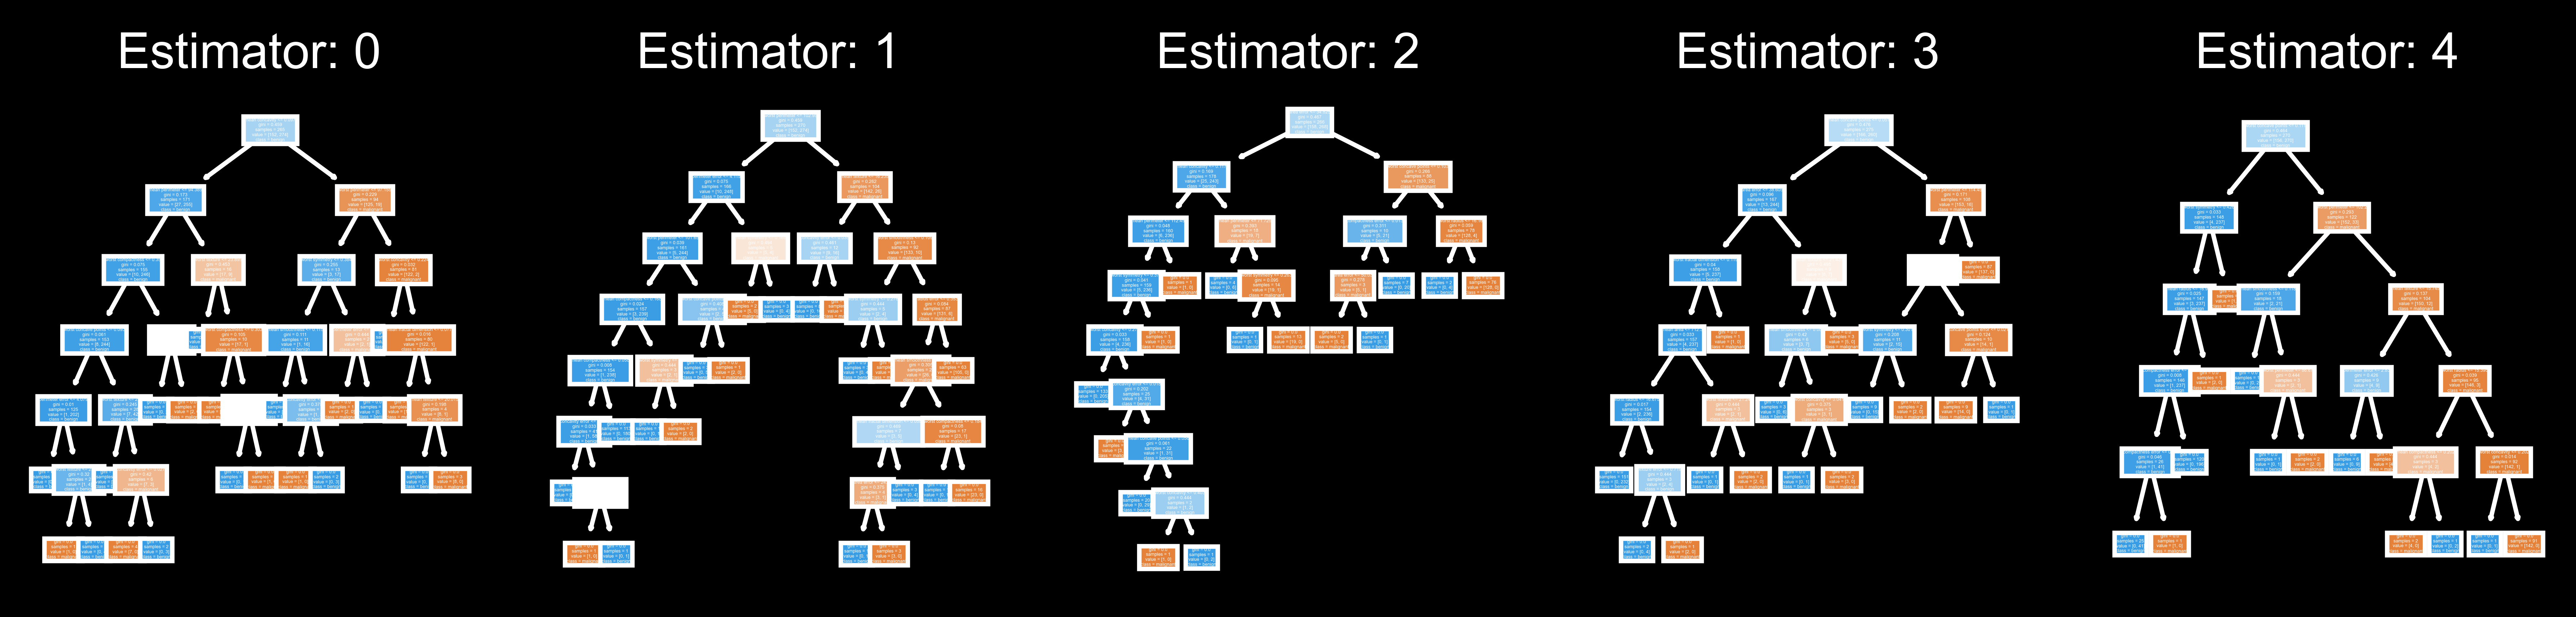

In [514]:
# This may not the best way to view each estimator as it is small
plt.style.use('dark_background')
fn=data.feature_names
cn=data.target_names
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(rf.estimators_[index],
                   feature_names = fn, 
                   class_names=cn,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
# fig.savefig('rf_5trees.png')

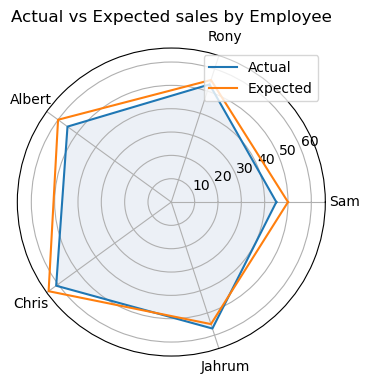

In [557]:
employee = ["Sam", "Rony", "Albert", "Chris", "Jahrum"]
actual = [45, 53, 55, 61, 57, 45]
expected = [50, 55, 60, 65, 55, 50]
 
# Initialise the spider plot by setting figure size and polar projection
plt.figure(figsize=(4, 4))
plt.subplot(polar=True)
 
theta = np.linspace(0, 2 * np.pi, len(actual))
 
# Arrange the grid into number of sales equal parts in degrees
lines, labels = plt.thetagrids(range(0, 360, int(360/len(employee))), (employee))
 
# Plot actual sales graph
plt.plot(theta, actual)
plt.fill(theta, actual, 'b', alpha=0.1)
 
# Plot expected sales graph
plt.plot(theta, expected)
 
# Add legend and title for the plot
plt.legend(labels=('Actual', 'Expected'), loc=1)
plt.title("Actual vs Expected sales by Employee")
 
# Dsiplay the plot on the screen
plt.show()

In [612]:
rf_features.head(10)
# .sort_values('Feature')

Feature      Coef
3     lp_cat_canny  0.092704
1           lp_all  0.083756
4     lp_all_canny  0.072808
5   lp_ratio_canny  0.066018
16          eye_h2  0.054544
13          eye_w2  0.053754
19       eye_ratio  0.047795
8           to_ctr  0.047381
0           lp_cat  0.044556
7       size_ratio  0.044394

In [594]:
rf_features['Feature'].head(8).tolist()
actual = rf_features['Coef'].head(8).tolist()
actual += [actual[0]]
actual

[0.09270416325881785,
 0.08375560920514111,
 0.07280824617889294,
 0.06601765177636844,
 0.05454410628095124,
 0.053754317766398926,
 0.04779526855345661,
 0.04738076292907326,
 0.09270416325881785]

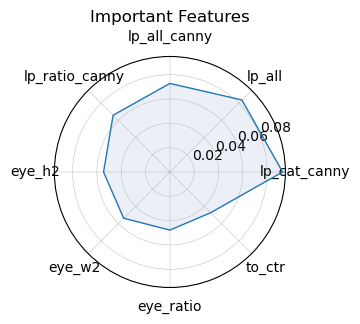

In [615]:
employee = ["Sam", "Rony", "Albert", "Chris", "Jahrum"]

actual = [45, 53, 55, 61, 57, 45]
expected = [50, 55, 60, 65, 55, 50]
employee = rf_features['Feature'].head(8).tolist()
actual = rf_features.head(8)['Coef'].tolist()
actual += [actual[0]]
 
# Initialise the spider plot by setting figure size and polar projection
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(polar=True)
ax.grid(lw=.3)
 
theta = np.linspace(0, 2 * np.pi, len(actual))
 
# Arrange the grid into number of sales equal parts in degrees
lines, labels = plt.thetagrids(range(0, 360, int(360/len(employee))), (employee))
 
# Plot actual sales graph
plt.plot(theta, actual,lw=1)
plt.fill(theta, actual, 'b', alpha=0.1)
 
# Plot expected sales graph
# plt.plot(theta, expected)
 
# Add legend and title for the plot
# plt.legend(labels=('Actual', 'Expected'), loc=1)
plt.title("Important Features")
# ax.set_xticklabels([])
# ax.set_yticklabels([])
 
# Dsiplay the plot on the screen
plt.show()

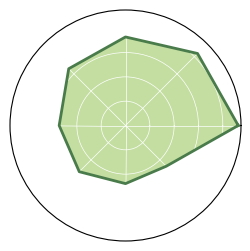

In [611]:
employee = rf_features['Feature'].head(8).tolist()
actual = rf_features.head(8)['Coef'].tolist()
actual += [actual[0]]
 
# Initialise the spider plot by setting figure size and polar projection
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(polar=True)
ax.grid(lw=.5,color='white')
 
theta = np.linspace(0, 2 * np.pi, len(actual))
 
# Arrange the grid into number of sales equal parts in degrees
lines, labels = plt.thetagrids(range(0, 360, int(360/len(employee))), (employee))
 
# Plot actual sales graph
plt.plot(theta, actual,lw=2, color = '#497B4B')
plt.fill(theta, actual, '#88BE43', alpha=0.5)
 
# Plot expected sales graph
# plt.plot(theta, expected)
 
# Add legend and title for the plot
# plt.legend(labels=('Actual', 'Expected'), loc=1)
# plt.title("Important Features")
ax.set_xticklabels([])
ax.set_yticklabels([])
 
# Dsiplay the plot on the screen
plt.show()

fig.savefig('./plot/feature_polar.pdf', bbox_inches='tight', transparent=True)

In [321]:
# y_scores

### B. Hyperparameter Tuning
The most important parameter is the number of random features to sample at each split point (max_features).  Another important parameter for random forest is the number of trees (n_estimators). Ideally, this should be increased until no further improvement is seen in the model.

In [ ]:
# # define models and parameters
# model = RandomForestClassifier()
# n_estimators = [10, 100, 1000]
# max_features = ['sqrt', 'log2']
# # define grid search
# grid = dict(n_estimators=n_estimators,max_features=max_features)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X_train, y_train)

In [ ]:
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# # for mean, stdev, param in zip(means, stds, params):
# #     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# # Use best model on test set
# rf_best = grid_result.estimator
# rf_best.fit(X_train,y_train)
# y_predict = rf_best.predict(X_test)
# pd.DataFrame(confusion_matrix(y_test, y_predict),\
#              columns=['Predict-Bad (0)','Predict-Good (1)'],\
#             index=['Bad (0)','Good (1)'])

In [ ]:
# pred = randomforest.predict(X_test)
# print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
# print('Classification report (Random Forests):\n\n',classification_report(y_test,y_predict))

In [ ]:
# # Random Forests ROC curve
# y_scores = rf_best.predict_proba(X_test)
# fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, 'b', label = 'AUC_forests = %0.3f' % roc_auc)

# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.title('ROC of Random Forests')
# plt.show()

In [ ]:
# Not necessarily better

### C. Feature importatnce

In [559]:
rf_features = pd.DataFrame(list(zip(X_train.columns,np.transpose(randomforest.feature_importances_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)
rf_features.head(6)

Feature      Coef
3     lp_cat_canny  0.092704
1           lp_all  0.083756
4     lp_all_canny  0.072808
5   lp_ratio_canny  0.066018
16          eye_h2  0.054544
13          eye_w2  0.053754

In [ ]:
# Logistic regression has higher AUC score
# But Random forest has better precision

## 3. AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=100, random_state=0)
ada.fit(X_train,y_train)

In [ ]:
pred = ada.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred))
print('ROC AUC score:',roc_auc_score(y_test,ada.predict_proba(X_test)[:, 1]),'\n')
print('Classification report (AdaBoost):\n\n',classification_report(y_test,pred))

In [ ]:
# AdaBoost ROC curve
plot_roc('AdaBoost', ada)

In [ ]:
ada_features = pd.DataFrame(list(zip(X_train.columns,np.transpose(ada.feature_importances_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)
ada_features.head()

## 4. Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                max_depth=1, random_state=0).fit(X_train, y_train)

In [ ]:
pred = gb.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred))
print('ROC AUC score:',roc_auc_score(y_test,gb.predict_proba(X_test)[:, 1]),'\n')
print('Classification report (XGBoost):\n\n',classification_report(y_test,pred))

In [ ]:
# Gradient Boost ROC curve
plot_roc('Gradient Boost', gb)

In [ ]:
gb_features = pd.DataFrame(list(zip(X_train.columns,np.transpose(gb.feature_importances_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)
gb_features.head()

## 5. XGBoost

In [ ]:
X_train.columns
# X_train.columns[X_train.columns.duplicated()]

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train,y_train)

In [ ]:
pred = xgb.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred))
print('ROC AUC score:',roc_auc_score(y_test,xgb.predict_proba(X_test)[:, 1]),'\n')
print('Classification report (XGBoost):\n\n',classification_report(y_test,pred))

In [ ]:
# XGBoost ROC curve
plot_roc('XGBoost', xgb)

In [ ]:
xgb_features = pd.DataFrame(list(zip(X_train.columns,np.transpose(xgb.feature_importances_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)
xgb_features.head()

## Examine model results

In [57]:
# Specify the model to check
model = lm_best
model = randomforest
# model = xgb
# model = ada

In [58]:
# For train test split
test_df = pd.DataFrame(y_test)
test_df['prob'] = model.predict_proba(X_test)[:, 1]
test_df

label   prob
0        0  0.310
1        1  0.930
2        1  0.750
3        1  0.865
4        1  0.825
..     ...    ...
362      1  0.920
363      1  0.985
364      1  0.925
365      0  0.360
366      0  0.230

[367 rows x 2 columns]

In [59]:
# # For proper split
# test_df = df[df.video.isin(test_video)].reset_index(drop=True)
# # [['video','filename','label']]

# threshold = 0.56
# y_predict = (model.predict_proba(X_test)[:, 1] >= threshold).tolist()
# test_df['label'] = y_test
# test_df['pred'] = [0 if x==False else 1 for x in y_predict]
# test_df['prob'] = model.predict_proba(X_test)[:, 1]
# test_df['prob_max'] = test_df.groupby(['video'])['prob'].transform(max)

In [60]:
# test_df

### Compare prediction and label

In [61]:
# test_df

In [62]:
# test_df.video.nunique()

In [63]:
test_result = test_df[['label','prob']]
# test_result.columns = ['label','Probability']
# test_result

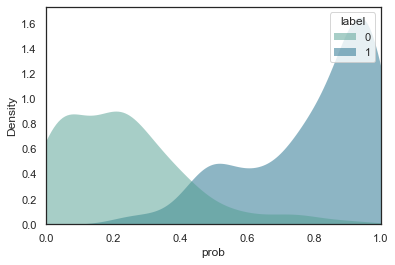

In [64]:
# Logistic regression
fig, ax = plt.subplots()
ax = sns.kdeplot(data=test_result, x="prob", hue="label",
            fill=True, common_norm=True, palette="crest",
            alpha=.5, linewidth=0);
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim([0,1]);

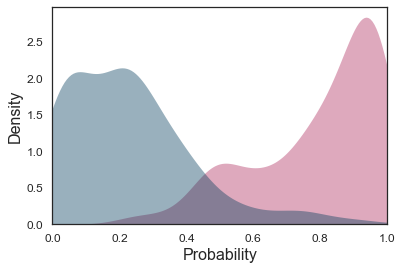

In [65]:
# Set color palette
colors = ["#ff9e9b","#b4c8e0"]
colors = ["#013B5B","#AE285C"]
sns.set_palette(sns.color_palette(colors))

# Logistic regression
fig, ax = plt.subplots()
ax = sns.kdeplot(data=test_result, x="prob", hue="label",
            fill=True, common_norm=False,
#             palette="crest",
            alpha=.4, linewidth=0,
            legend=False);
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel("Probability",fontsize=16)
ax.set_ylabel("Density",fontsize=16)
ax.tick_params(labelsize=12)

plt.xlim([0,1]);
fig.savefig('./plot/kde_rf.pdf', bbox_inches='tight', transparent=True)

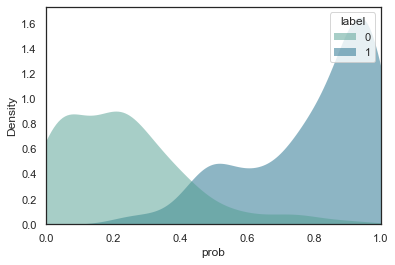

In [66]:
# Random forest
fig, ax = plt.subplots()
ax = sns.kdeplot(data=test_result, x="prob", hue="label",
            fill=True, common_norm=True,
            palette="crest",
            alpha=.5, linewidth=0);
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim([0,1]);

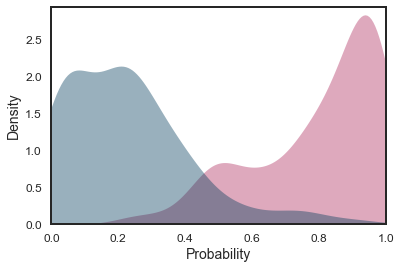

In [79]:
# Set color palette
colors = ["#ff9e9b","#b4c8e0"]
colors = ["#013B5B","#AE285C"]
sns.set_palette(sns.color_palette(colors))

# Random forest
fig, ax = plt.subplots()
ax = sns.kdeplot(data=test_result, x="prob", hue="label",
            fill=True, common_norm=False,
#             palette="crest",
            alpha=.4, linewidth=0,
            legend=False);
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel("Probability",fontsize=16)
ax.set_ylabel("Density",fontsize=16)
ax.tick_params(labelsize=12)

plt.xlabel('Probability',fontsize=14)
plt.ylabel('Density',fontsize=14)
# plt.title('Receiver Operating Characteristic Curve',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

plt.xlim([0,1])
plt.ylim([0,2.95]);
fig.savefig('./plot/kde_rf.pdf', bbox_inches='tight', transparent=True)

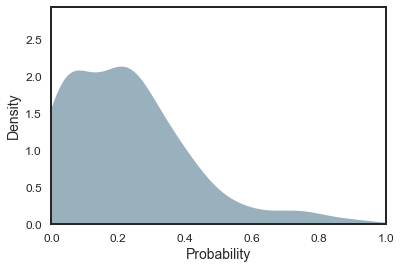

In [80]:
# Separate to save individual plot
# Set color palette
colors = ["#ff9e9b","#b4c8e0"]
colors = ["#013B5B","#AE285C"]
sns.set_palette(sns.color_palette(colors))

# Random forest
fig, ax = plt.subplots()
ax = sns.kdeplot(data=test_result[test_result.label==0], x="prob", hue="label",
            fill=True, common_norm=False,
#             palette="crest",
            alpha=.4, linewidth=0,
            legend=False);
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel("Probability",fontsize=16)
ax.set_ylabel("Density",fontsize=16)
ax.tick_params(labelsize=12)

plt.xlabel('Probability',fontsize=14)
plt.ylabel('Density',fontsize=14)
# plt.title('Receiver Operating Characteristic Curve',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

plt.xlim([0,1])
plt.ylim([0,2.95]);
fig.savefig('./plot/kde_rf_bad.pdf', bbox_inches='tight', transparent=True)

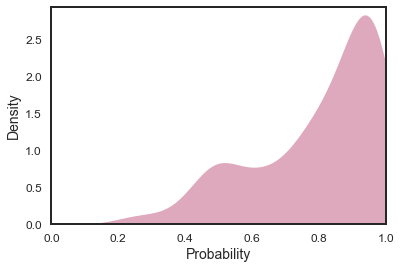

In [81]:
# Separate to save individual plot
# Set color palette
colors = ["#ff9e9b","#b4c8e0"]
colors = ["#AE285C"]
sns.set_palette(sns.color_palette(colors))

# Random forest
fig, ax = plt.subplots()
ax = sns.kdeplot(data=test_result[test_result.label==1], x="prob", hue="label",
            fill=True, common_norm=False,
#             palette="crest",
            alpha=.4, linewidth=0,
            legend=False);
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel("Probability",fontsize=16)
ax.set_ylabel("Density",fontsize=16)
ax.tick_params(labelsize=12)

plt.xlabel('Probability',fontsize=14)
plt.ylabel('Density',fontsize=14)
# plt.title('Receiver Operating Characteristic Curve',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

plt.xlim([0,1])
plt.ylim([0,2.95]);
fig.savefig('./plot/kde_rf_good.pdf', bbox_inches='tight', transparent=True)

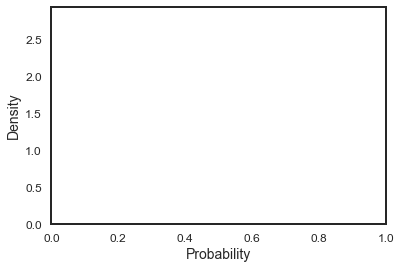

In [83]:
fig, ax = plt.subplots()
ax.set_xlabel("Probability",fontsize=16)
ax.set_ylabel("Density",fontsize=16)
ax.tick_params(labelsize=12)

plt.xlabel('Probability',fontsize=14)
plt.ylabel('Density',fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12);
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

plt.xlim([0,1])
plt.ylim([0,2.95]);
fig.savefig('./plot/kde_rf_frame.pdf', bbox_inches='tight', transparent=True)

In [ ]:
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    
move_legend(ax, "upper left")

### Feature importance bar plot

In [ ]:
import altair as alt
from vega_datasets import data

source = data.barley()

alt.Chart(source).mark_bar().encode(
    x='sum(yield)',
    y='variety',
    color='site',
)

In [ ]:
source

In [ ]:
model_name = 'Logistic Regression'
feature_df = lr_features
def feature_dataframe(model_name,feature_df):
    # feature_df = feature_df.head()
    feature_df_t = np.transpose(feature_df)
    new_header = feature_df_t.iloc[0]
    feature_df_t = feature_df_t[1:]
    feature_df_t.columns = new_header
    feature_df_t['model'] = model_name
    return feature_df_t

In [ ]:
lr_feature_df = feature_dataframe(model_name,feature_df)
rf_feature_df = feature_dataframe('Random Forest',rf_features)
ada_feature_df = feature_dataframe('AdaBoost',ada_features)
gb_feature_df = feature_dataframe('Gradient Boost',gb_features)
xgb_feature_df = feature_dataframe('XGBoost',xgb_features)

features_all = pd.concat([lr_feature_df,rf_feature_df,ada_feature_df,gb_feature_df,xgb_feature_df],axis=0).\
                reset_index(drop=True)
features_all

In [ ]:
features_all.columns

In [ ]:
features_all = pd.concat([lr_features,rf_features,ada_features,gb_features,xgb_features],axis=0)
features_all['model'] = ['e Logistic Regression']*26+['d Random Forest']*26+['c AdaBoost']*26+\
                        ['b Gradient Boost']*26+['a XGBoost']*26
features_all.columns = ['Feature','Coefficient','model']
features_all['order'] = [0]*26+[1]*26+[2]*26+[3]*26+[4]*26
features_all

In [ ]:
feature_rank = alt.Chart(features_all[26:]).mark_bar().encode(
                x='sum(Coefficient):Q',
                y=alt.Y('Feature:N', sort='-x'),
                color='model',
#                 order = 'order'
)
feature_rank.configure_title(fontSize=14).configure(background='#F6F7F2')
# feature_rank.save('feature_rank.pdf')

In [ ]:
# rf_feature_rank = 
bars = alt.Chart(rf_features).mark_bar().encode(
    x='Coef:Q',
    y=alt.Y("Feature:O",sort='-x')
)
text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='Coef:Q'
)

(bars + text).properties(height=900)

In [ ]:
rf_features

In [ ]:
source

In [ ]:
import altair as alt
from vega_datasets import data

source = data.wheat()

bars = alt.Chart(source).mark_bar().encode(
    x='wheat:Q',
    y="year:O"
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='wheat:Q'
)

(bars + text).properties(height=900)

In [ ]:
lr_features['model'] = ['Logistic Regression']*26
lr_features

In [ ]:
def plot_roc(model_name,model):
    y_scores = model.predict_proba(X_test)
    fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC of '+ model_name)
    plt.show()

In [ ]:
y_scores = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

In [ ]:
fpr

In [ ]:
fpt_tpr = pd.DataFrame(fpr,tpr).reset_index()
fpt_tpr.columns=['fpr','tpr']
fpt_tpr

In [ ]:
alt.Chart(fpt_tpr).mark_line().encode(
    alt.X('tpr:Q'),
    alt.Y('fpr:Q'),
#     color='sex:N'
#     , axis=alt.Axis(format='%')
)

No handles with labels found to put in legend.


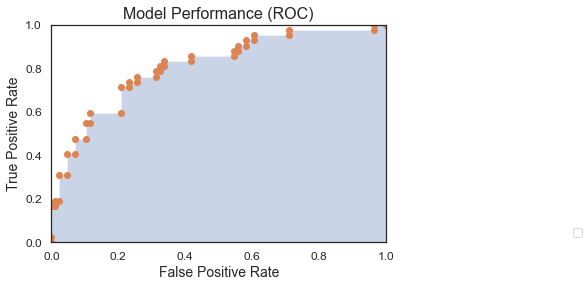

In [389]:
fig, ax = plt.subplots()

# pd.DataFrame(tpr,fpr).plot.area(alpha=0.4)
y_scores = lm.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.stackplot(fpr, tpr,alpha=0.3)
# plt.plot(fpr, tpr, 'cadetblue', linewidth=3.5, label = 'Logistic Regression = %0.3f' % roc_auc)
plt.plot(fpr, tpr,'o')
# plt.plot([0, 1], [0, 1],'k--',label = 'Random guess = 0.5')

plt.legend(loc = 'lower right',bbox_to_anchor=(1.6, 0))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.title('Model Performance (ROC)',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

# fig.savefig('../plot/ROC_lr_2.pdf', bbox_inches='tight', transparent=True)

In [ ]:
fig, ax = plt.subplots()

# pd.DataFrame(tpr,fpr).plot.area(alpha=0.4)
y_scores = lm.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.stackplot(fpr, tpr,alpha=0.3)
plt.plot(fpr, tpr, 'cadetblue', linewidth=3.5, label = 'Logistic Regression = %0.3f' % roc_auc)
# plt.plot([0, 1], [0, 1],'k--',label = 'Random guess = 0.5')

plt.legend(loc = 'lower right',bbox_to_anchor=(1.6, 0))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.title('Model Performance (ROC)',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

# fig.savefig('../plot/ROC_lr_2.pdf', bbox_inches='tight', transparent=True)

In [ ]:
len(fpr)

In [39]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Classification and ROC analysis
random_state = np.random.RandomState(0)
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=3)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

In [16]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

In [54]:
test

array([ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199])

In [185]:
df = data.copy()
# Train test split
X = df.iloc[:,:-1]

mapping = {'bad':0, 'good':1}
y = df['label'].map(mapping)

X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)

features = ['lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny', 'lp_all_canny', 'lp_ratio_canny',\
            'cat_x', 'cat_y',
            'face_size', 'size_ratio', 'to_ctr',\
            'num_eye','num_ear', 'num_nose', 
            'eye_w1', 'eye_w2', 'eye_w', 'eye_h1', 'eye_h2', 'eye_h',
            'eye_size', 'eye_ratio',
            'ear_w1', 'ear_w2', 'ear_w', 'ear_h1', 'ear_h2', 'ear_h',
            'eye_x1', 'eye_y1', 'eye_x2', 'eye_y2',
            'nose_x'
           ]

X = X[features]
# X = X.iloc[700:900,:]
X = np.array(X)

# y = y[700:900]
y = np.array(y)

X.shape,y.shape

((1832, 33), (1832,))

In [186]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing


from sklearn.linear_model import LogisticRegression
classifier = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(solver='newton-cg',C=100000))

# classifier = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
#                           C=100000)  # No regularization

# from sklearn.ensemble import RandomForestClassifier
# classifier = RandomForestClassifier(n_estimators=200)
# classifier = make_pipeline(preprocessing.StandardScaler(), RandomForestClassifier(n_estimators=200))


# import xgboost as xgb
# from xgboost import XGBClassifier
# xgb = XGBClassifier()
# classifier = make_pipeline(preprocessing.StandardScaler(), XGBClassifier())

# from sklearn.ensemble import AdaBoostClassifier
# ada = AdaBoostClassifier(n_estimators=100, random_state=0)
# classifier = make_pipeline(preprocessing.StandardScaler(), AdaBoostClassifier(n_estimators=100, random_state=0))

scores = cross_val_score(classifier, X, y, cv=5)
scores

array([0.52861035, 0.66485014, 0.71584699, 0.74043716, 0.7431694 ])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('adaboostclassifier',
                 AdaBoostClassifier(n_estimators=100, random_state=0))])


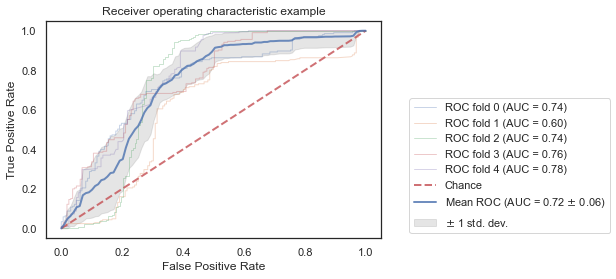

In [190]:
classifier = make_pipeline(preprocessing.StandardScaler(), AdaBoostClassifier(n_estimators=100, random_state=0))

print(classifier)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

cv = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
ax.legend(loc = 'lower right',bbox_to_anchor=(1.7, 0))
plt.show()

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               validate_parameters=None, verbosity=None))])


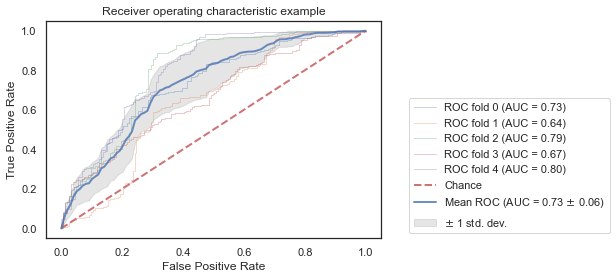

In [187]:
classifier = make_pipeline(preprocessing.StandardScaler(), XGBClassifier())

print(classifier)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

cv = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
ax.legend(loc = 'lower right',bbox_to_anchor=(1.7, 0))
plt.show()

RandomForestClassifier(n_estimators=200)


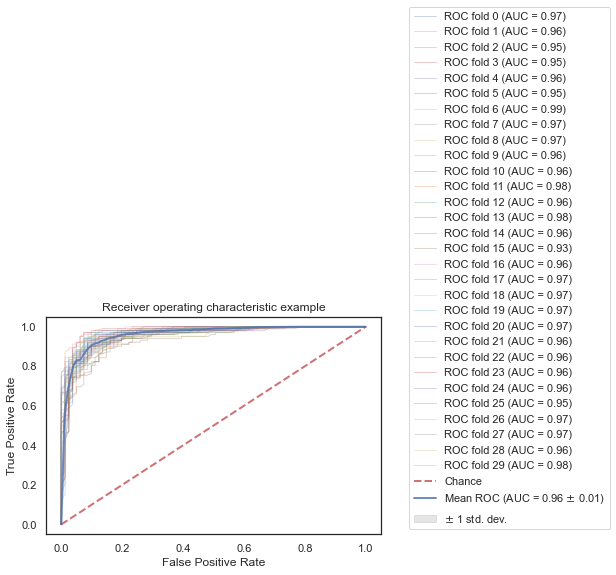

In [233]:
classifier = make_pipeline(preprocessing.StandardScaler(), RandomForestClassifier(n_estimators=200))

classifier = RandomForestClassifier(n_estimators=200)
print(classifier)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

cv = StratifiedKFold(n_splits=6)

from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)



fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
ax.legend(loc = 'lower right',bbox_to_anchor=(1.7, 0))
plt.show()

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=100, solver='newton-cg'))])


KeyError: "None of [Int64Index([ 202,  203,  204,  205,  206,  207,  208,  209,  210,  211,\n            ...\n            1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831],\n           dtype='int64', length=1374)] are in the [columns]"

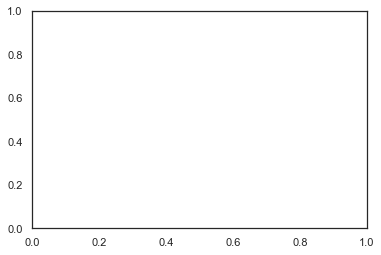

In [325]:
classifier = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(solver='newton-cg',C=100,penalty='l2'))

print(classifier)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

cv = StratifiedKFold(n_splits=4)

from sklearn.model_selection import RepeatedStratifiedKFold
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
ax.legend(loc = 'lower right',bbox_to_anchor=(1.7, 0))
plt.show()

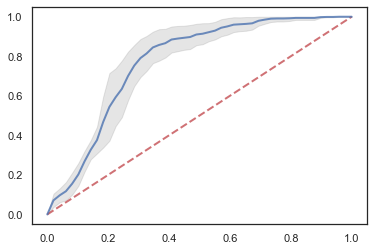

In [227]:
fig, ax = plt.subplots()
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8);

In [199]:
len(mean_fpr)

100

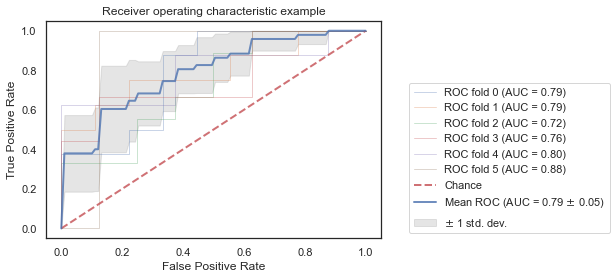

In [74]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
ax.legend(loc = 'lower right',bbox_to_anchor=(1.7, 0))
plt.show()

In [75]:
X.shape

(100, 804)

In [76]:
y.shape

(100,)

In [80]:
for i, (train, test) in enumerate(cv.split(X, y)):
    print(i, X[train][0].shape)

0 (804,)
1 (804,)
2 (804,)
3 (804,)
4 (804,)
5 (804,)


### wandb VIZ

In [ ]:
# import wandb
# wandb.init(project="visualize-sklearn")

In [ ]:
# # Visualize single plot
# wandb.sklearn.plot_confusion_matrix(y_test, y_predict, labels)

### 1. Check the best frame for each video file

In [ ]:
pd.set_option('display.max_columns', None)
test_df[test_df.video=="IMG_0253"].drop(columns=['eyes','ears','nose','video']).sort_values('prob',ascending=False)

In [ ]:
# randomforest
results = test_df[test_df['prob'] == test_df['prob_max']][['video','filename','label','prob']]
results

In [ ]:
# Selected frame

import cv2 as cv

# Text parameters 
font = cv.FONT_HERSHEY_SIMPLEX
org = (800, 100)
fontScale = 2
color = (255, 0, 0)
thickness = 2

# List of lp_ratio
# lp_ratios = [round(x,4) for x in FP.lp_ratio.tolist()]

# Prepare list of best frames
selected_img = results.filename.tolist()
test_len = len(results)

# Plots
subplot_row = test_len//3+1
fig, axs = plt.subplots(figsize=(20, 10*subplot_row))
for i, filename in enumerate(selected_img[:]):
    img = cv.imread('OpenCV_blur/frame_all_1/'+filename)
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
#     # Annotate lp_ratio
#     lp_ratio = str(lp_ratios[i])
#     rgb = cv.putText(rgb, lp_ratio,org, font,  
#                    fontScale, color, thickness, cv.LINE_AA) 
    plt.subplot(subplot_row,3,i+1)
    plt.imshow(rgb)
    plt.title(filename)

plt.show()

### 2. Check false positive images

In [ ]:
# False-positive: bad photos but predicted to be good
FP = test_df[(test_df.label==0) & (test_df.pred==1)]
FP_img = FP.filename.tolist()
FP_len = len(FP_img)
FP_len

In [ ]:
# False-positive: bad photos but predicted to be good
FP = results[(results.label==0)]
FP_img = FP.filename.tolist()
FP_len = len(FP_img)
FP_len

In [ ]:
import cv2 as cv

# Plots
subplot_row = FP_len//3+1
fig, axs = plt.subplots(figsize=(20, 10*subplot_row))
for i, filename in enumerate(FP_img[:]):
    img = cv.imread('OpenCV_blur/frame_all_1/'+filename)
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
#     # Annotate lp_ratio
#     lp_ratio = str(lp_ratios[i])
#     rgb = cv.putText(rgb, lp_ratio,org, font,  
#                    fontScale, color, thickness, cv.LINE_AA) 
    plt.subplot(subplot_row,3,i+1)
    plt.imshow(rgb)
    plt.title(filename)

plt.show()

In [ ]:
# Went back to check the images
# These are not great but indeed are the best among the given options